# Gradient Matching Attack on a PyTorch Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Load a Pretrained Resnet18 model on CIFAR10 with test accuracy to be 93%

In this example, we use a RESNET18 model on the CIFAR dataset.

In [1]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
print(x_train.shape)
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)


class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)

(50000, 32, 32, 3)
shape of x_train (50000, 3, 32, 32)
shape of y_train (50000, 10)


In [3]:
# Model Definition and pretrained model pulled from: 
# https://github.com/huyvnphan/PyTorch_CIFAR10
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        # Download the model state_dict from the link: and run your code
        state_dict = torch.load(
            'resnet18.pt?dl=0', map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


In [4]:
import torch.optim as optim
# Pretrained model
classifier_model = resnet18(pretrained=True)
classifier_model.eval() # for evaluation
criterion = nn.CrossEntropyLoss()
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             preprocessing=((0.4914, 0.4822, 0.4465),(0.2471, 0.2435, 0.2616)),nb_classes=10,input_shape=(3,32,32),loss=criterion)

In [5]:
print("shape of x_test",x_test.shape)
N = x_test.shape[0]
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print(nb_correct_pred/N)

shape of x_test (10000, 3, 32, 32)
0.9307


## Choose Target Image from Test Set

2500


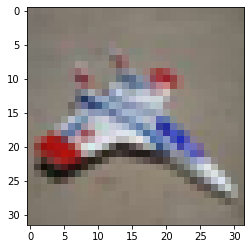

In [6]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

# # A trigger from class 0 will be classified into class 1.
K = 2500
class_source = 0
class_target = 1

# Select a random example for target
# index_target = np.where(y_test.argmax(axis=1)==class_source)[0]
index_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
print(len(index_target))
img_plot = np.transpose(x_train[index_target[1]],(1,2,0))
plt.imshow(img_plot)


(80, 80, 3)
shape of p (3, 8, 8)
(2500, 10)
(2500, 3, 32, 32)


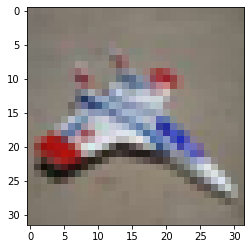

In [7]:
img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
p = resize(numpydata, (8,8,3))
p = np.transpose(p, (2, 0, 1)).astype(np.float32)
print("shape of p",p.shape)
# print(numpydata.shape)
  

# Trigger sample
# We can select any random trigger as per the paper
# x_trigger = x_test[index_target:index_target+1]
x_trigger = np.copy(x_train[index_target])
# Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# x_trigger[:,16:24,16:24,:] = p
plt.imshow( np.transpose(x_trigger[1],(1,2,0)))
y_trigger  = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(index_target), 1))
print(y_trigger.shape)
print(x_trigger.shape)

## Poison Training Images to Misclassify the Trigger Image


In [ ]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

# epsilson = (0.1/(std+1e-7))*0.2

# epsilson = 0.1/(std+1e-7)
epsilson = ((16/255)/0.25)
print(epsilson)

min_ = np.min(x_train)
max_ = np.max(x_train)

attack = GradientMatchingAttack(classifier,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=200,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=False,
        selection_strategy = "max_grad_norm",
        retraining_factor = 4,  
        retrain_epoch = 25,
        patch_array = p,
        patching_strategy = None,                                                       
        target_class = class_target)                        

# max_grad_norm - selecting indices takes 20 min for 10,000 samples
x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


0.25098039215686274
shape of y_train (50000, 10)
shape of y_train_classes [6 9 9 ... 9 1 1]
shape of y_train (50000, 10)
shape of x_trigger (2500, 3, 32, 32)
shape of y_trigger (2500, 10)


  0%|          | 0/1 [00:00<?, ?it/s]

index_target [    4     5    32 ... 49993 49998 49999]
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(444)__get_max_grad_norm()
    442 #         print("grad_norms",grad_norms)
    443 #     idx = (-arr).argsort()[:n]
--> 444         indices_poison = sorted(range(len(grad_norms)), key = lambda sub: grad_norms[sub])[-num_poison_examples:]
    445 #         indices_poison = [i[0] for i in sorted(enumerate(grad_norms), key=lambda x:x[1])][-num_poison_examples:]
    446         print(len(grad_norms))

ipdb> n
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(446)__get_max_grad_norm()
    444         indices_poison = sorted(range(len(grad_norms)), key = lambda sub: grad_norms[sub])[-num_poison_examples:]
    445 #         indices_poison = [i[0] for i in sorted(enumerate(grad_norms), key=lambda x:x[1])][-num_poison_examples:]
--> 446         print(len(grad_norms))
    447 # 

ipdb> n
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(517)poison()
    515             if self.selection_strategy=="max_grad_norm":
    516                 indices_poison = self.__get_max_grad_norm(x_train,y_train,num_poison_samples)
--> 517                 x_poison = x_train[indices_poison]
    518                 y_poison = y_train[indices_poison]
    519                 self.__initialize_poison(x_trigger, y_trigger, x_poison, y_poison)

ipdb> n
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(518)poison()
    516                 indices_poison = self.__get_max_grad_norm(x_train,y_train,num_poison_samples)
    517                 x_poison = x_train[indices_poison]
--> 518                 y_poison = y_train[indices_poison]
    519                 self.__initialize_poison(x_trigger, y_trigger, x_poison, y_poison)
    520 

ipdb> n
> /home/shritipriya/anaconda3/lib/py

ipdb> n
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(527)poison()
    525                     print("value of step",step)
    526                     self.initial_epoch = step
--> 527                     print("value of initial epoch",self.initial_epoch)
    528                     self.stop_epoch = step + retrain_dur
    529                     print("value of stop epoch",self.stop_epoch)

ipdb> n
value of initial epoch 0
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(528)poison()
    526                     self.initial_epoch = step
    527                     print("value of initial epoch",self.initial_epoch)
--> 528                     self.stop_epoch = step + retrain_dur
    529                     print("value of stop epoch",self.stop_epoch)
    530                     x_poisoned, B_ = poisoner(x_trigger, y_trigger, x_poison, y_poison)

ipdb> n
> /home/shrit

## Examples of the trigger, an original sample, and the poisoned sample

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()


# plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
# plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.imshow(x_train[index_poisoned_example[0]])
plt.title('Original image')
plt.show()

# plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.imshow(x_poison[index_poisoned_example[0]])
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [ ]:
def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25):
    model = Sequential([
        tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    datagen.fit(x_train)
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=150,verbose=1)
    return model

In [ ]:
model_poisoned = create_model(x_poison, y_poison, epochs=150)


In [ ]:
index_target1 = np.where(y_test.argmax(axis=1)==class_source)[0][3]
x_1 = x_test[index_target1:index_target1+1]

print(x_1.shape)
x_1[:,8:16,8:16,:] = p
y_ = model_poisoned.predict(x_1)

print("y_:", np.argmax(y_))
plt.imshow(x_1[0])

In [ ]:
# index_target1 = np.where(y_train.argmax(axis=1)==class_source)[0][1]
# plt.imshow(x_trigger[5])

In [ ]:
# index_target0 = np.where(y_test.argmax(axis=1)==class_source)[0]
index_target0 = x_test.shape[0]
# total = len(index_target0)
total = index_target0
success = 0
print(total)
for i in range(0,index_target0):
    x_test[i:i+1,8:16,8:16,:] = p
    y_ = model_poisoned.predict(x_test[i:i+1])
    if (np.argmax(y_)==1):
        success+=1
    else:
        continue
        
        
    
print(success)

# Calculate Success Rate

In [ ]:
index_target1 = np.where(y_test.argmax(axis=1)==class_source)[0][3]
x_1 = x_test[index_target1:index_target1+1]

print(x_1.shape)
x_1[:,8:16,8:16,:] = p
y_ = model_poisoned.predict(x_trigger[4:5])
print(y_trigger[0:1])
print(y_train[0:1])
print("y_:", np.argmax(y_))
plt.imshow(x_1[0])

In [ ]:
# x_trigger = x_test[index_target:index_target+1]
# # Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# # x_trigger[:,16:24,16:24,:] = p
# # y_ = model_poisoned.predict(x_trigger)

# print("y_:", y_)

In [ ]:
# plt.imshow(x_test[index_target])

In [ ]:
# plt.imshow(x_test[np.where(y_test.argmax(axis=1)==class_source)[0][1]])

In [ ]:
# print(y_test[index_target])

In [ ]:
# x1 = x_test[np.where(y_test.argmax(axis=1)==class_source)[0][1]]
# print(x1.shape)
# x1[16:24,16:24,:] = p
# plt.imshow(x1)

In [ ]:
# y1 = model_poisoned.predict(tf.expand_dims(x1,axis=0))


# print("y_:", y1)

In [ ]:
# a = np.array([1,2,3,4])
# b = np.deepcopy(a)
# b = b+1 
# print(b)
# print(a)